In [22]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [23]:
import numpy as np
import pickle

# Load arrays
data = np.load('lstm_data.npz')
X_seq = data['X']
y = data['y']

# Load LabelEncoder
with open('shot_encoder.pkl', 'rb') as f:
    shot_encoder = pickle.load(f)

Current Working Directory: C:\Users\gushi\LTU\TennisStrokePrediction
Index(['Pt', 'Set1', 'Set2', 'Gm1', 'Gm2', 'Gm#', 'TB?', 'rallyLen',
       'player_score', 'opponent_score', 'shot1', 'shot2', 'shot3', 'shot4',
       'winner_array', 'unforced_array', 'is_deuce', 'is_break_point',
       'is_game_point', 'point_diff', 'total_sets_played',
       'total_games_played', 'is_tiebreak', 'match_pressure_score',
       'rally_intensity', 'fatigue_index', 'estimated_stamina'],
      dtype='object')


### RNN Implementation

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNLSTMShotPredictor(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(CNNLSTMShotPredictor, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=2, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=2, padding=1)
        self.bn = nn.BatchNorm1d(128)

        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True  # Now using BiLSTM
        )

        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(hidden_size * 2, num_classes)  # *2 for bidirectional

    def forward(self, x):
        # x: [B, T, F] → [B, F, T]
        x = x.permute(0, 2, 1)

        x = F.relu(self.conv1(x))
        x = F.relu(self.bn(self.conv2(x)))

        # Back to [B, T, F]
        x = x.permute(0, 2, 1)

        lstm_out, _ = self.lstm(x)
        out = torch.cat((lstm_out[:, -1, :self.lstm.hidden_size], lstm_out[:, 0, self.lstm.hidden_size:]), dim=1)
        out = self.dropout(out)
        return self.classifier(out)



#### Training using label encoding

In [25]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pickle
import ast

# Copy the original data 
processed_data_rnn = processed_data.copy()

# Expand winner_array and unforced_array to 48 columns each
winner_df = pd.DataFrame(
    processed_data_rnn['winner_array'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' ', dtype=np.float32)).tolist(),
    index=processed_data_rnn.index
)
winner_df.columns = [f'winner_{i}' for i in range(winner_df.shape[1])]

unforced_df = pd.DataFrame(
    processed_data_rnn['unforced_array'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' ', dtype=np.float32)).tolist(),
    index=processed_data_rnn.index
)
unforced_df.columns = [f'unforced_{i}' for i in range(unforced_df.shape[1])]
processed_data_rnn.drop(columns=['winner_array', 'unforced_array'], inplace=True)
processed_data_rnn = pd.concat([processed_data_rnn, winner_df, unforced_df], axis=1)
processed_data_rnn = processed_data_rnn.copy()

# Filter out serve tokens from shot4 only
def is_rally(tok):
    return isinstance(tok, str) and tok[0] not in {'0', '4', '5', '6'}

processed_data_rnn = processed_data_rnn[processed_data_rnn['shot4'].apply(is_rally)].copy()

# Refit LabelEncoder ONLY on shot1-4 after shot4 filtering 
all_shots = pd.concat([
    processed_data_rnn['shot1'],
    processed_data_rnn['shot2'],
    processed_data_rnn['shot3'],
    processed_data_rnn['shot4']
]).astype(str)

label_encoder = LabelEncoder()
label_encoder.fit(all_shots)

# Save the encoder
with open("label_encoder_full.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# Encode all shots
for col in ['shot1', 'shot2', 'shot3', 'shot4']:
    processed_data_rnn[col] = label_encoder.transform(processed_data_rnn[col].astype(str))

# Keep only XGBoost-important features + shot1, shot2, shot3 
required_shots = {'shot1', 'shot2', 'shot3', 'shot4'}

# Define target and features
target = processed_data_rnn['shot4']
features = processed_data_rnn.drop(columns=['shot4'])

# Build 3-shot input sequences 
context_cols = [col for col in features.columns if col not in ['shot1', 'shot2', 'shot3']]
X_sequences = []

for _, row in features.iterrows():
    context = row[context_cols].values.astype(np.float32)
    shot1 = np.insert(context, 0, row['shot1'])
    shot2 = np.insert(context, 0, row['shot2'])
    shot3 = np.insert(context, 0, row['shot3'])
    X_sequences.append(np.stack([shot1, shot2, shot3]))

# Normalize features
X_scaled = np.array(X_sequences)

# Convert to tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(target.values, dtype=torch.long)

# Train/Val/Test Split (60/20/20)
from sklearn.model_selection import train_test_split

X_tensor = torch.tensor(np.load("X_dynamic.npy"), dtype=torch.float32)
y_tensor = torch.tensor(np.load("y_dynamic.npy"), dtype=torch.long)

# Split as usual
from sklearn.model_selection import train_test_split

X_train_np, X_temp_np, y_train_np, y_temp_np = train_test_split(
    X_tensor.numpy(), y_tensor.numpy(), test_size=0.3, random_state=42
)
X_val_np, X_test_np, y_val_np, y_test_np = train_test_split(
    X_temp_np, y_temp_np, test_size=2/3, random_state=42
)

# Convert back to PyTorch
X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.long)
X_val = torch.tensor(X_val_np, dtype=torch.float32)
y_val = torch.tensor(y_val_np, dtype=torch.long)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_test = torch.tensor(y_test_np, dtype=torch.long)


print("✅ Final preprocessing complete.")
print(f"Train shape: {X_train.shape} — Target shape: {y_train.shape}")
print(f"Num classes in encoder: {len(label_encoder.classes_)} — Unique labels in target: {len(np.unique(y_train.numpy()))}")


✅ Final preprocessing complete.
Train shape: torch.Size([48353, 3, 118]) — Target shape: torch.Size([48353])
Num classes in encoder: 52 — Unique labels in target: 47


In [26]:
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from collections import Counter 

train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val, y_val)
test_dataset  = TensorDataset(X_test, y_test)

# --- Create DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [29]:
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1, weight=None):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.weight = weight

    def forward(self, x, target):
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        if self.weight is not None:
            loss = loss * self.weight[target]
        return loss.mean()

# Class weights
y_train_np = y_train.cpu().numpy()
all_classes = np.arange(len(label_encoder.classes_))
weights_array = np.ones(len(all_classes), dtype=np.float32)
computed_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_np), y=y_train_np)
for i, cls in enumerate(np.unique(y_train_np)):
    weights_array[cls] = computed_weights[i]

class_weights_tensor = torch.tensor(weights_array, dtype=torch.float32).to(device)

# Use custom loss with smoothing
criterion = LabelSmoothingLoss(classes=len(label_encoder.classes_), smoothing=0.05, weight=class_weights_tensor)

# Optimizer, Scheduler
model = CNNLSTMShotPredictor(
    num_classes=len(label_encoder.classes_),
    input_size=X_train.shape[2],
    hidden_size=64,
    num_layers=1
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0007, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)

# Training loop
num_epochs = 100
best_val_acc = 0
patience = 15
patience_counter = 0
min_delta = 0.001
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()

    # --- Evaluate on train set ---
    model.eval()
    correct_train = 0
    total_train = 0

    with torch.no_grad():
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == targets).sum().item()
            total_train += targets.size(0)

    train_acc = correct_train / total_train
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    # --- Evaluate on validation set ---
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)

    val_loss /= len(val_loader)
    val_acc = correct_val / total_val
    print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")

    # --- Early stopping with min_delta ---
    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"⛔ Early stopping triggered. Best validation loss: {best_val_loss:.4f}")
            break

Epoch [1/100], Loss: 3.8626, Train Accuracy: 0.1166
Validation Accuracy: 0.1110, Validation Loss: 3.7724
Epoch [2/100], Loss: 3.7402, Train Accuracy: 0.1033
Validation Accuracy: 0.1038, Validation Loss: 3.6720
Epoch [3/100], Loss: 3.6428, Train Accuracy: 0.0822
Validation Accuracy: 0.0871, Validation Loss: 3.5961
Epoch [4/100], Loss: 3.5767, Train Accuracy: 0.0855
Validation Accuracy: 0.0905, Validation Loss: 3.5490
Epoch [5/100], Loss: 3.5395, Train Accuracy: 0.0910
Validation Accuracy: 0.0954, Validation Loss: 3.5099
Epoch [6/100], Loss: 3.5071, Train Accuracy: 0.0719
Validation Accuracy: 0.0717, Validation Loss: 3.5035


KeyboardInterrupt: 

In [13]:
from sklearn.metrics import accuracy_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9930


In [ ]:
from sklearn.metrics import accuracy_score, top_k_accuracy_score

model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = torch.argmax(outputs, dim=1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs)

all_labels_np = np.array(all_labels)
all_preds_np = np.array(all_preds)
all_probs_np = np.array(all_probs)

acc_top1 = accuracy_score(all_labels_np, all_preds_np)
acc_top3 = top_k_accuracy_score(all_labels_np, all_probs_np, k=3, labels=np.arange(len(label_encoder.classes_)))
acc_top5 = top_k_accuracy_score(all_labels_np, all_probs_np, k=5, labels=np.arange(len(label_encoder.classes_)))

print(f"Test Accuracy (Top-1): {acc_top1:.4f}")
print(f"Test Accuracy (Top-3): {acc_top3:.4f}")
print(f"Test Accuracy (Top-5): {acc_top5:.4f}")


In [14]:
y_random = y_tensor[torch.randperm(len(y_tensor))]
model.eval()
with torch.no_grad():
    output = model(X_tensor.to(device))
    pred = torch.argmax(output, dim=1).cpu()
    print("Random-label accuracy:", (pred == y_random).float().mean().item())


Random-label accuracy: 0.11381501704454422


C:\Users\gushi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gushi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gushi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

          b1       1.00      1.00      1.00       860
          b2       1.00      1.00      1.00      1518
          b3       1.00      1.00      1.00      1803
          f1       1.00      1.00      1.00      2719
          f2       1.00      1.00      1.00      1550
          f3       1.00      1.00      1.00      2186
          h1       1.00      1.00      1.00        15
          h2       1.00      1.00      1.00        19
          h3       1.00      1.00      1.00        18
          i1       1.00      1.00      1.00        16
          i2       1.00      1.00      1.00        19
          i3       1.00      1.00      1.00        22
          j1       1.00      1.00      1.00        29
          j2       1.00      1.00      1.00        17
          j3       0.93      1.00      0.96        26
          k1       0.00      0.00      0.00         3
          k3       0.00      0.00      0.00         3
          l1       0.76    

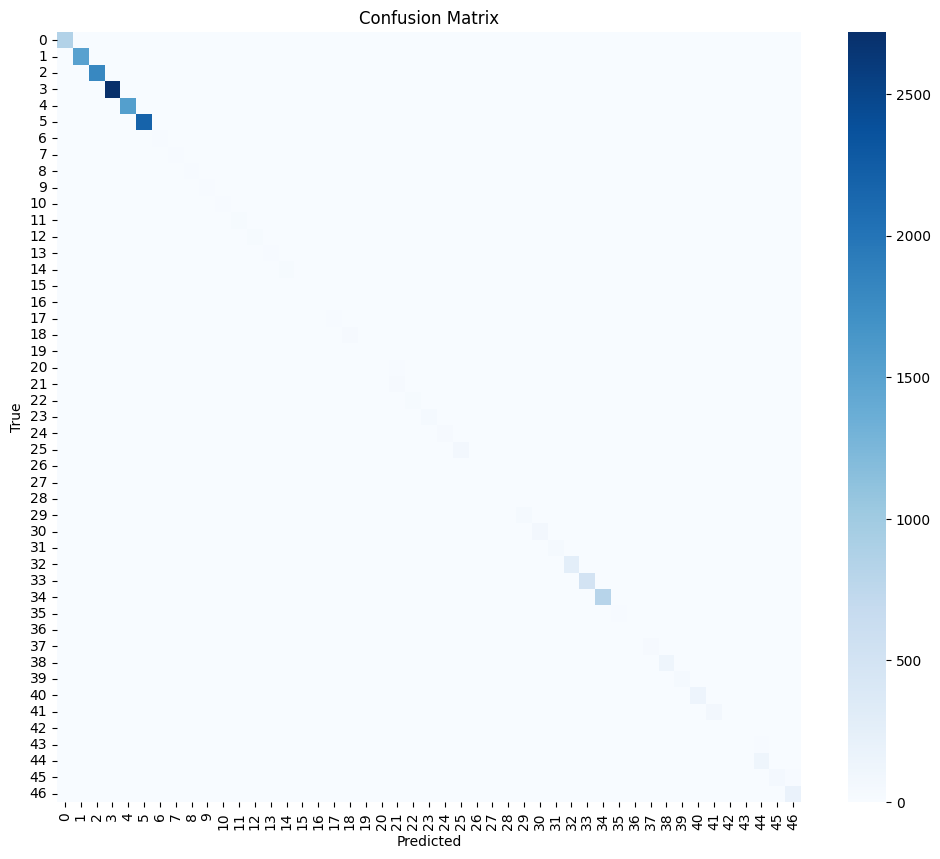

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predicted and actual labels (already on CPU)
predicted_labels = np.array(all_preds)
true_labels = np.array(all_labels)

# Compute present classes
unique_classes = np.unique(true_labels)

# Print classification report with proper labels
print(classification_report(true_labels, predicted_labels, labels=unique_classes, target_names=label_encoder.inverse_transform(unique_classes)))

# Plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=unique_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", annot=False, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


f1: 9433
f3: 7715
b3: 6125
b2: 5517
f2: 5350
s3: 2904
b1: 2834
s2: 1686
s1: 940
z3: 625
